In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Basic data preparation, modelling and analysis for binary classification (Census)

## Train a model only with a statistical performance purpose

In [2]:
import sys
sys.path.append("../")

import pickle
import time
from sklearn.datasets import fetch_openml

from classif_basic.data_preparation import train_valid_test_split, set_target_if_feature, automatic_preprocessing
from classif_basic.model import train_naive_xgb, pickle_save_model, prediction_train_valid_by_task, compute_best_fscore
from classif_basic.model_analysis import features_importances_from_pickle, augment_train_valid_set_with_results

from classif_basic.model_analysis import plot_tree, get_df_first_splits

In [3]:
# set your statistics purposes
model_task = 'classification'
stat_criteria = 'auc'

t0 = time.time()

### Prepare data

Fix precise % of population distribution (sex: Male, Female) and % of loan granted according to sex, to inspect the effects of FairDream.

In [4]:
# preparing the dataset on clients for binary classification
#from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True)

X = data.data
Y = (data.target == '>50K') * 1

In [5]:
dataset = X.copy()
dataset['target'] = Y
dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,0
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,1
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,0
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,0


In [6]:
# here, "treatment" is saw as being 'Male' and not 'Female'

df_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==1)]
df_no_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==0)]
df_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==1)]
df_no_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==0)]

print(df_response_if_feature.shape[0])
print(df_no_response_if_feature.shape[0])
print(df_response_if_not_feature.shape[0])
print(df_no_response_if_not_feature.shape[0])


# % of men selected by the initial data
df_response_if_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_feature.shape[0])

9918
22732
1769
14423


0.3037672281776417

In [7]:
# % of women selected by the initial data
df_response_if_not_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_not_feature.shape[0])

0.07267573230352081

In [8]:
len_dataset = 20_000

percentage_feature= 70
percentage_response_if_feature=70
percentage_response_if_not_feature=10

sexist_dataset = set_target_if_feature(
    df_response_if_feature=df_response_if_feature,
    df_no_response_if_feature=df_no_response_if_feature,
    df_response_if_not_feature=df_response_if_not_feature,
    df_no_response_if_not_feature=df_no_response_if_not_feature,
    len_dataset=len_dataset,
    percentage_feature=percentage_feature,
    percentage_response_if_feature=percentage_response_if_feature,
    percentage_response_if_not_feature=percentage_response_if_not_feature)

len_dataset: 20000
nb indivs feature with response: 9800
nb indivs feature with no response: 4200
nb indivs not_feature with response: 600
nb indivs not_feature with no response: 5400


In [9]:
X = sexist_dataset.loc[: , dataset.columns != 'target']
Y = sexist_dataset['target']

In [10]:
Y

6248     1
40461    1
8139     1
1563     1
1354     1
        ..
16727    0
34525    0
11167    0
10894    0
47665    0
Name: target, Length: 20000, dtype: int64

To not split the original features, we choose to label-encode them (i.e. associate each category's value with a number):

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

X_category = X.loc[:, X.dtypes == "category"]

le = LabelEncoder()
X_category = X_category.apply(le.fit_transform)

# for further interpretation, to get back the original categories
# X_category.apply(le.inverse_transform)

We then reconstitute the dataset, and check that it only contains non-categorical values that XGBoost can handle to do its splits.

In [12]:
X_non_category = X.loc[:, X.dtypes != "category"]

X = pd.concat([X_non_category, X_category], axis=1)
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
6248,39.0,116546.0,10.0,0.0,0.0,50.0,3,15,2,11,0,4,1,38
40461,50.0,145419.0,14.0,7688.0,0.0,45.0,5,12,2,11,0,4,1,38
8139,49.0,105959.0,10.0,0.0,0.0,41.0,0,15,2,0,0,4,1,38
1563,35.0,455469.0,13.0,0.0,0.0,40.0,3,9,2,2,0,2,1,38
1354,68.0,260198.0,13.0,0.0,0.0,40.0,4,9,2,11,0,4,1,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16727,44.0,290521.0,9.0,0.0,0.0,40.0,3,11,6,3,4,2,0,38
34525,22.0,31102.0,10.0,0.0,0.0,4.0,8,15,4,14,3,1,0,34
11167,42.0,270147.0,14.0,0.0,0.0,40.0,1,12,4,9,1,4,0,38
10894,19.0,162954.0,9.0,0.0,0.0,30.0,3,11,4,11,3,4,0,38


### Bring your own model 

If you want to bring your own model, you have to set 3 features:

1. uncorrected_model_path
Save your model in uncorrected_model_path, for fairness analysis on relevant features
Ex: uncorrected_model_path = "/work/data/models/uncorrected_model.pkl"

2. X_train_valid, Y_train_valid
pd.DataFrame with your inputs and targets on train&valid set, of shape(nb_individuals,)

3. Y_pred_train_valid
np.ndarray with the predicted label (i.e. class) or value, of shape(nb_individuals,)

### Automatically train a model statistically performant, regardless of fairness

We here introduce additional interaction constraints, to reflect causal interpretation on the features (TODO later: option of the function "train_naive_xgb")

In [13]:
X_train, X_valid, X_train_valid, X_test, Y_train, Y_valid, Y_train_valid, Y_test = train_valid_test_split(
    X=X,
    Y=Y, 
    model_task=model_task)

In [14]:
Y_valid.shape

(2550,)

In [15]:
X_train.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass', 'education', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

Training model with 14 features, on 14450 rows (valid 2550 rows, test 3000 rows) 
[0]	validation_0-auc:0.89392	validation_1-auc:0.89390
[100]	validation_0-auc:0.95703	validation_1-auc:0.95035
[104]	validation_0-auc:0.95727	validation_1-auc:0.95044
len(thresholds): 2505
(2550,)
Best Threshold=0.372733, with F-Score=0.893


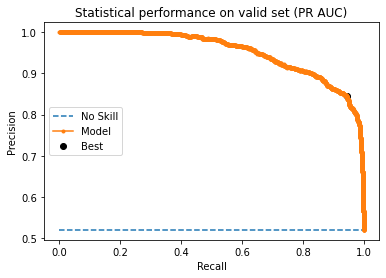

In [16]:
# save the uncorrected model, to then sort its features by importances
save_model=True
uncorrected_model_path = "/work/data/models/uncorrected_model.pkl"

Y_pred_train_valid = train_naive_xgb(
    X_train=X_train,
    X_valid=X_valid,
    X_train_valid=X_train_valid,
    X_test=X_test,
    Y_train=Y_train,
    Y_valid=Y_valid,
    Y_train_valid=Y_train_valid,
    Y_test=Y_test,
    model_task=model_task,
    stat_criteria=stat_criteria,
    save_model=save_model)

In [17]:
augment_train_valid_set_with_results("uncorrected", X_train_valid, Y_train_valid, Y_pred_train_valid, model_task)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country,target_train_valid,predicted_uncorrected,true_positive_uncorrected,false_positive_uncorrected,true_negative_uncorrected,false_negative_uncorrected
46592,54.0,68684.0,9.0,0.0,0.0,44.0,3,11,2,2,0,4,1,38,0,1,0,1,0,1
48088,51.0,170086.0,13.0,0.0,0.0,45.0,5,9,2,12,0,4,1,38,1,1,1,0,0,1
24821,35.0,258037.0,9.0,0.0,0.0,40.0,1,11,2,2,0,4,1,4,1,1,1,0,0,1
33033,42.0,384236.0,14.0,7688.0,0.0,40.0,3,12,2,9,0,4,1,38,1,1,1,0,0,1
37473,52.0,145333.0,13.0,0.0,0.0,60.0,3,9,0,11,1,4,1,38,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11999,17.0,120676.0,7.0,0.0,0.0,16.0,3,1,4,11,3,4,0,38,0,0,0,1,1,0
28870,65.0,143118.0,9.0,0.0,2206.0,10.0,8,11,6,14,4,4,0,38,0,0,0,1,1,0
14249,53.0,239990.0,9.0,0.0,0.0,40.0,3,11,2,2,0,4,1,38,1,1,1,0,0,1
3965,58.0,71283.0,9.0,0.0,0.0,38.0,3,11,2,13,0,4,1,38,1,1,1,0,0,1


We now see that this process with basic data preparation, modelling and integration of the results in a DataFrame (as storage of the model) is very fast (in seconds):

In [18]:
t1 = time.time()

print(f"Basic modelling took {round(t1 - t0)} seconds")

Basic modelling took 3 seconds


# Decomposition in Trees: Coherent Structure?

In [19]:
file = open(uncorrected_model_path,'rb')
xgb_basic = pickle.load(file)

xgb_basic

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]]',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=7, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=7, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [24]:
booster = xgb_basic
get_max_split_feature=False
nb_min_trees = 4 #None

df_first_splits = get_df_first_splits(booster=booster, 
                                      get_max_split_feature=get_max_split_feature,
                                      nb_min_trees=nb_min_trees)
df_first_splits

,trees_index,nb_trees
first_splitting_feature,,
sex<1,"[5, 7, 17, 27, 52, 66]",6
capital-gain<4243.5,"[34, 41, 47, 61, 79, 101]",6
occupation<9,"[22, 31, 39, 45, 71, 89]",6
capital-gain<7073.5,"[18, 26, 30, 57, 67]",5
relationship<1,"[0, 1, 2, 3]",4
marital-status<2,"[49, 68, 83, 104]",4
capital-gain<57,"[50, 60, 85, 98]",4


With feature interaction constraints on sex being not uncoherent ancestor of 'age', 'race' or 'native-country' the splitting of trees seem more coherent. 

TODO: now, how to set other causal parenthoods (e.g. 'relationship' can not be a causal ancestor of 'education', I think?) May be some links have to be sacrified, in order to draw efficient splits...

first_splitting_feature: sex<1


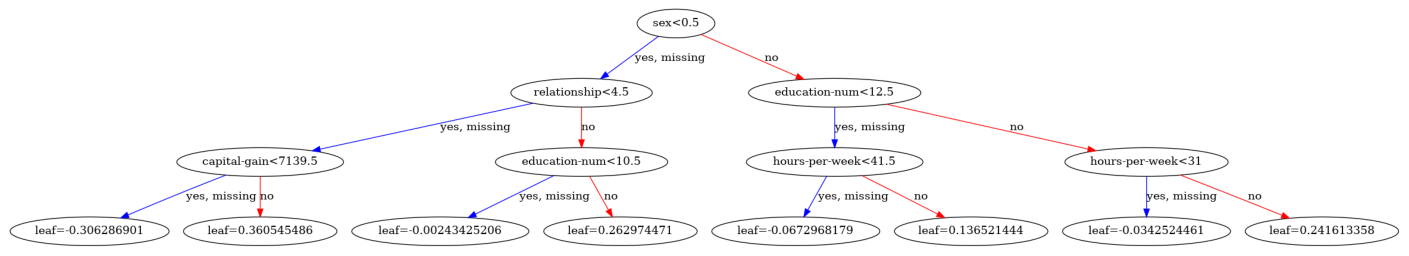

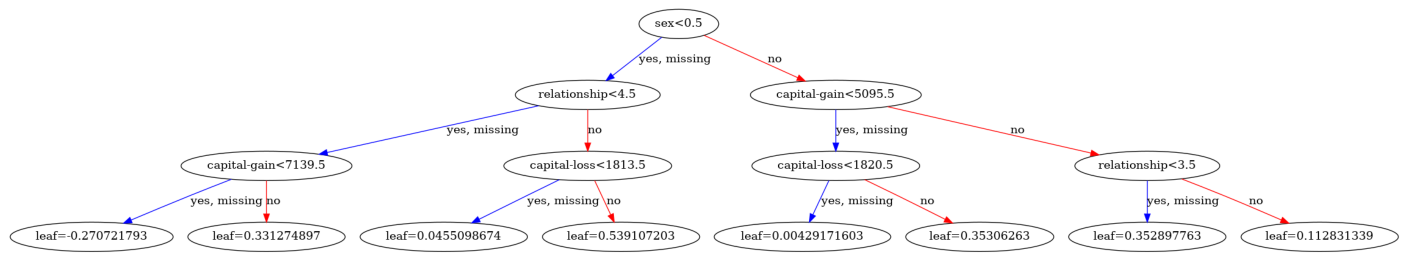

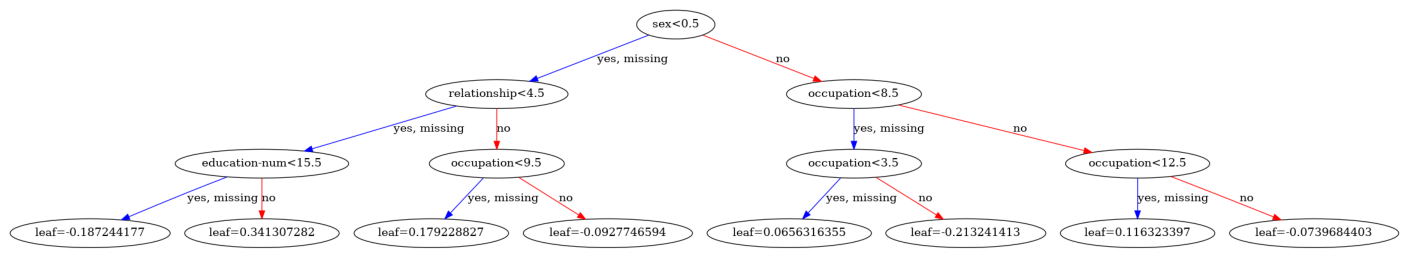

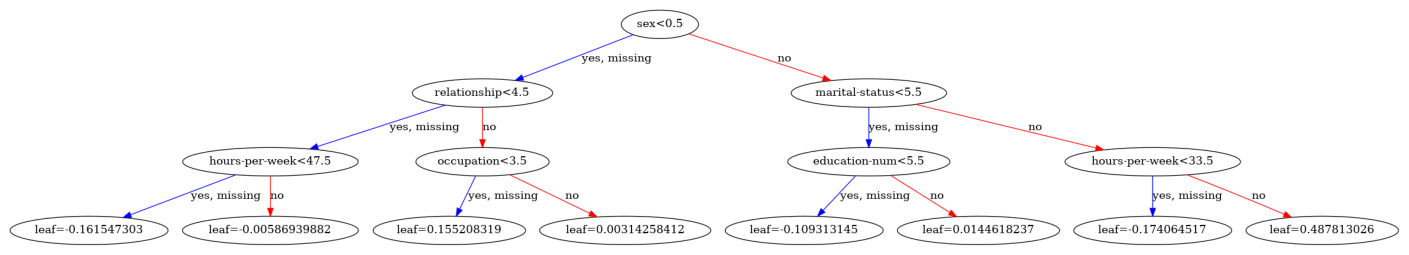

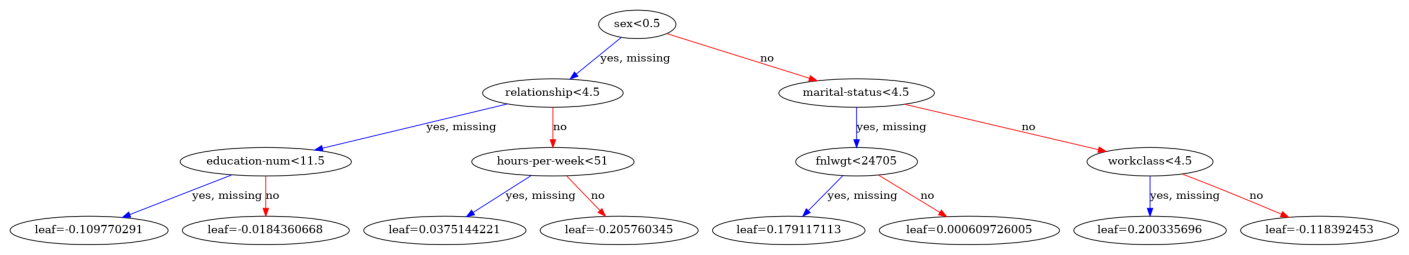

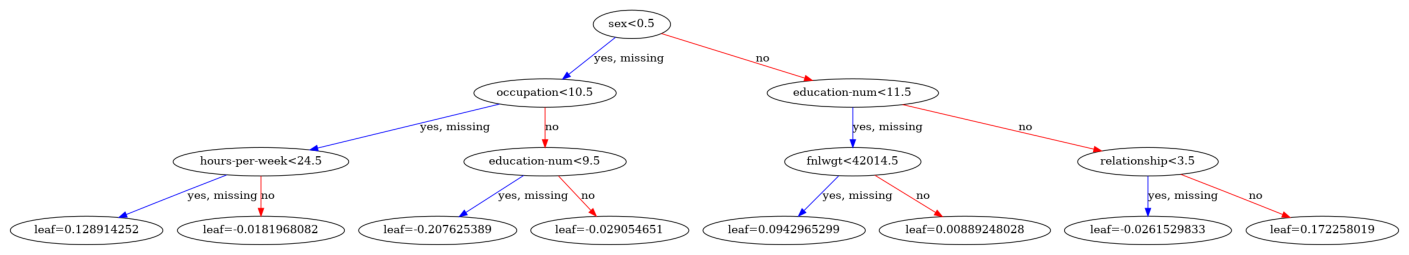

In [21]:
first_splitting_feature = df_first_splits.index[0]

print(f"first_splitting_feature: {first_splitting_feature}")

for num_trees in df_first_splits["trees_index"][first_splitting_feature]:
    
    plot_tree(
        booster=xgb_basic,
        num_trees=num_trees)

Parallell with the feature importance: aggregation over trees, but no "sense" or hierarchy between features... 

#Conclusion#
- The features importances does not reflect the structures of the trees
- The structures of the trees do not (systematically) follow a causal hierarchy (e.g. splitting on the income before the age) 
=> Further tests: the structures of trees need to be causally constrained (even if the split on "capital_gain" before "education_num" on a tree brought a bigger node purity on a tree number_k, that order would be forbidden as unrealistic)

Intuition: only keep the leaves that make sense 

Incident questions to realise this selection, or constraint, on trees: 
n_estimators = 1000, then why n_trees = 109?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

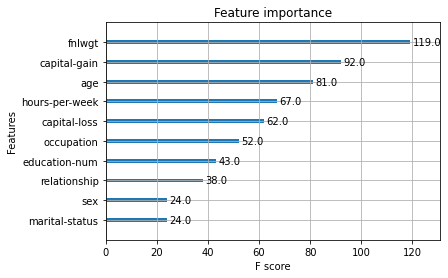

In [22]:
from xgboost.plotting import plot_importance 

# importance_type : str, default "weight"
        #How the importance is calculated: either "weight", "gain", or "cover"
        #* "weight" is the number of times a feature appears in a tree
        
plot_importance(
    booster=xgb_basic,
    importance_type="weight",
    max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

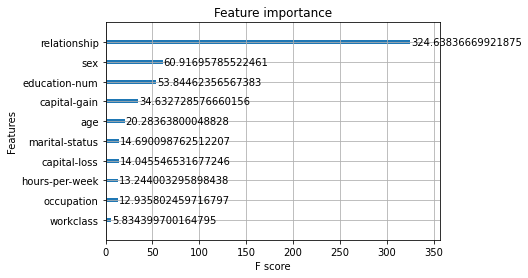

In [23]:
#* "gain" is the average gain of splits which use the feature
plot_importance(
    booster=xgb_basic,
    importance_type="gain",
    max_num_features=10)